## Recurrent Neural Networks

Recurrent neural networks - or RNNs - are built specifically to deal with sequence data. For example, suppose you have a sequence of text of movie reviews and would like to classify their sentiment, or a sequence of stock prices and you would like to predict the next one. These are all tasks well suited for an RNN.

To better understand, let's take a look at this blog post:

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

RNN's can take many different forms:

* Sequence of inputs to sequence of outputs
* Sequence of inputs to vector of output
* Vector of input to sequence of outps
* Encoder -> Decoder

We can take a closer look on p. 384 of Hands on Machine Learning

## Variable length sequences

If you have variable length inputs, like movie reviews which differ in length. A decent technique is to pick a fairly large input sequence length and zero padd all the inputs which are smaller. See here:

https://github.com/keras-team/keras/issues/40

If you have variable length output sequences - for example, when generating text. You can define a special end of sequence tag such as <EOS> and ignore any output past that tag.


## Issues with RNNs:

* Vanishing/Exploding gradients
* Take a long time to train
* Memory of first inputs tends to fad away making their long-term memory weak

## LSTM

* Much more capable of learning long-term dependencies
* Same structure as vanilla RNN, but has 4 neural networks inside
* Has two states which are passed to the next part of the sequence
* The first state is the **cell state** and only has small changes made to it and thus it is very easy for information to be passed forward.
* The first change we can make to the cell state is remove information from it. This is done with a **forget gate.** The forget gate is a fully connected neural net where the input is the concat of previous hidden state (not the cell state) and the sequence input. It is activated with a sigmoid and thus gives values from zero to one. A 1 means keep all the information.
* The second change we make to the cell state is decide which information should be added. To do this, we take the combined hidden and input and feed it through another fully connected layer activated by a sigmoid - this is the **input gate.** We also take this combined input and feed it through what I will call the **tanh gate.** This gate is a fully connected layer activated by a tanh function - like sigmoid but ranges from -1 to 1. We then combine these two gates output with pointwise multiplication - basically the input gate tells how much information to keep from the tanh gate.
* Now that we have our forget and remember values we will take the incoming cell state and multiply it by the forget values and add in the remember values.
* Lastly, we need to decide what to output which will also be our hidden state we carry forward.
* First, we take the combined input and hidden state through what I will call the **output gate.** This is a fully connected layer activated by a sigmoid.
* Then, we take the updated cell value and pass it through a tanh to force its values to range from -1 to 1 and multiply these values by the output gate - the output gate telling us what to keep.
* We carry this value forward as the hidden state and pass it through a softmax and a final fully connected layer to get our output.

## GRU

GRU is basically a simplified version of an LSTM that seems to perform just as well for most tasks and thus has been growing in popularity. To learn more about it take a look at the blog post or p. 406 of Hands on Machine learning.

There are also many other RNN architectures that we don't metion here.

## Word Embeddings

A very interesting challenge in NLP is: how do we represent the meaning of a word to a computer? One idea might be to reprsent words as a sparse vector the size of your vocabulary where each vector is all zeros except for a one at the appropriate index for that word. This has some pretty obvious drawbacks. One, it is very large. Two, is it really has no notion of how words are similar in their meanings.

One way we have solved some portion of these problems is by learning dense word embeddings. These embeddings - or vectors - should encode the meaning of a word sufficiently enough that we can hopefully compare vectors.

A technique to do this - there are many - is called **Continuous Bag-of-Words (CBOW)**. Also, referred to as word2vec, though, there is another flavor of word2vec. The idea is to use the context of a word as features to predict the target word.

What is the context? Simple - the words surrounding the target word. Usually, around +-2 words. You then define how big of a dimension you want for your embeddings - say 128.

Then, you train a neural network to find the best 128 dimension embeddings using the context words to predict the target word.

Note: an embedding is just a fancy name for a look-up table. An embedding takes in an index (for example, 1) and returns the vector it finds at that index, which in our example would be of size 128. The embedding table should have the same number of rows as vocabulary words.

And like anything involving gradient descent, our embeddings will basically start off with random numbers and we will use gradient descent to optimize them given our training data.

Let's see some code motiviated by the following (also see p.407 of hands on machine learning):

http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

https://github.com/FraLotito/continuous-bag-of-words

## CBOW Pytorch Example

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import defaultdict
import torch.distributions as distributions
import pandas as pd
from collections import Counter
%matplotlib inline

In [2]:
def make_data(tweets):
    data = []
    for tweet in tweets:
        tokens = tweet.split(" ")
        for i in range(2, len(tokens) - 2):
            context = [tokens[i - 2], tokens[i - 1],
                       tokens[i + 1], tokens[i + 2]]
            target = tokens[i]
            data.append((context, target))
    return data

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [54]:
df = pd.DataFrame.from_csv("../small_data/elonmusk_tweets.csv")
tweets = df.text.values
tweets = [t[2:-1] for t in tweets]
tweets[0]

'And so the robots spared humanity ... https://t.co/v7JUJQWfCv'

In [55]:
data = make_data(tweets)
data[:3]

[(['And', 'so', 'robots', 'spared'], 'the'),
 (['so', 'the', 'spared', 'humanity'], 'robots'),
 (['the', 'robots', 'humanity', '...'], 'spared')]

In [90]:
len(data)

30603

In [65]:
words = [w for t in tweets for w in t.split()]
common_words = [w for w,c in Counter(words).most_common() if c >=5]
vocab = set(common_words)
word_to_ix = {word: i for i, word in enumerate(vocab)}
print(len(common_words))

1216


In [79]:
def get_word_index(word):
    if word in word_to_ix:
        return word_to_ix[word]
    else:
        return len(word_to_ix)
    
def make_context_vector(context, get_word_index):
    idxs = [get_word_index(w) for w in context]
    tensor = torch.LongTensor(idxs)
    return Variable(tensor)

In [80]:
class CBOW(nn.Module):


    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, vocab_size)
        self.log_softmax = nn.LogSoftmax()


    def forward(self, inputs):
        ## view changes the size to be one row
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.log_softmax(out)
        return out
    

    def get_word_emdedding(self, word):
        word = Variable(torch.LongTensor([word_to_ix[word]]))
        return self.embeddings(word).view(1,-1)

In [86]:
cbow = CBOW(len(vocab)+1, 100, 128)

criterion = nn.NLLLoss()
optimizer = optim.Adam(cbow.parameters(), lr=.001)

In [87]:
def train_cbow(context, target):
    context_vector = make_context_vector(context, get_word_index)  
    model.zero_grad()
    log_probs = cbow(context_vector)
    loss = criterion(log_probs, Variable(
        torch.LongTensor([get_word_index(target)])))
    loss.backward()
    optimizer.step()
    return loss.data

In [93]:
n_epochs = 1
print_every = 1000
plot_every = 1000
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_epochs + 1):
    for context, target in data:
        loss = train_cbow(context, target)
        total_loss += loss

        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

/home/tyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

## Encoder-Decoder

## Example of RNN and LSTM using pytorch

Source: http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#sphx-glr-intermediate-char-rnn-generation-tutorial-py

In [3]:
female_names = []
name_weights = []
for year in range(2000,2017):
    with open("../small_data/baby_names/yob{}.txt".format(year), "r") as f:
        for line in f:
            columns = line.split(",")
            if columns[1] == 'F':
                female_names.append(columns[0])
                name_weights.append(int(columns[2].strip()))

In [4]:
female_names[:5]

['Emily', 'Hannah', 'Madison', 'Ashley', 'Sarah']

In [5]:
n_names = len(female_names)
print(n_names)

326418


In [6]:
name_weights[:5]

[25953, 23078, 19967, 17996, 17691]

In [7]:
unique_names_weights = defaultdict(int)
for i in range(n_names):
    name = female_names[i]
    weight = name_weights[i]
    unique_names_weights[name] = unique_names_weights[name] + weight

In [8]:
unique_names = list(unique_names_weights.keys())
unique_weights = list(unique_names_weights.values())
unique_probabilities = np.array(unique_weights) / sum(unique_weights)

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.result_gate = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, input, hidden, cell):
        input_combined = torch.cat((input, hidden), 1)
        
        forget_gate_value = self.sigmoid(self.forget_gate(input_combined))
        input_gate_value = self.sigmoid(self.input_gate(input_combined))
        tanh_gate_value = self.tanh(self.tanh_gate(input_combined))
        output_gate_value = self.sigmoid(self.output_gate(input_combined))
        
        input_tanh_combined = input_gate_value * tanh_gate_value
        
        cell_next = cell * forget_gate_value + input_tanh_combined
        hidden_next = self.tanh(cell_next) * output_gate_value
        output = self.result_gate(hidden_next)

        return output, hidden_next, cell_next

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [10]:
letters = set([c.lower() for name in female_names for c in name])
letters_to_index = {l:i for i,l in enumerate(letters)}
index_to_letter = {i:l for l, i in letters_to_index.items()}

In [11]:
n_letters = len(letters) + 1

In [12]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li].lower()
        tensor[li][0][letters_to_index[letter]] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [letters_to_index[line[li].lower()] for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingPair():
    return np.random.choice(unique_names, p=unique_probabilities, size=1)[0]

def randomTrainingExample():
    line = randomTrainingPair()
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return input_line_tensor, target_line_tensor

In [13]:
criterion = nn.CrossEntropyLoss()
lstm = LSTM(n_letters, 128, n_letters)

optimizer = optim.Adam(lstm.parameters(), lr=.001)

def train(input_line_tensor, target_line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initHidden()

    optimizer.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden, cell = lstm(input_line_tensor[i], hidden, cell)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    optimizer.step()

    return output, loss.data[0] / input_line_tensor.size()[0]

In [14]:
n_iters = 20000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 27s (5000 25%) 2.0953
3m 21s (10000 50%) 0.7251
5m 16s (15000 75%) 0.8468
7m 20s (20000 100%) 1.3765


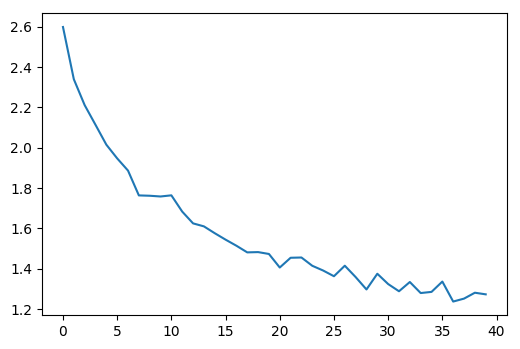

In [15]:
plt.plot(all_losses)

In [16]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A'):
    input = Variable(inputTensor(start_letter))
    hidden = lstm.initHidden()
    cell = lstm.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden, cell = lstm(input[0], hidden, cell)
        sm = nn.Softmax(dim=1)
        softmax_out = sm(Variable(output.data)).data.numpy()[0]
        topi = np.random.choice(range(len(softmax_out)), p=softmax_out)
        if topi == n_letters - 1:
            break
        else:
            letter = index_to_letter[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

In [146]:
sample('E')

'Elizabeth'